# Study of Time delays and magnification of lensed gravitational waves.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json
from scipy.stats import gaussian_kde

from ler.rates import LeR

## data generation

In [3]:
# data generation
ler = LeR(
    npool=4,
    event_type="BBH",
    verbose=False, 
    # geocent_time_min=1126259462.4,
    # geocent_time_max=1126259462.4+365*24*3600*10,
    )

In [3]:
# 2 or more image detectable 
lensed_params = ler.selecting_n_lensed_detectable_events(
    size=10000,
    batch_size=50000,
    snr_threshold=8,
    num_img=2,
    resume=True,
    output_jsonfile="n_lensed_params_bbh.json",
    meta_data_file="meta_data_lensed_bbh.json",
)

collected number of events =  0


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]


collected number of events =  248
total number of events =  50000
total lensed rate (yr^-1): 1.2319491538512728


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


collected number of events =  488
total number of events =  100000
total lensed rate (yr^-1): 1.2120790062085103


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


collected number of events =  732
total number of events =  150000
total lensed rate (yr^-1): 1.2120790062085103


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


collected number of events =  972
total number of events =  200000
total lensed rate (yr^-1): 1.2071114692978195


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


collected number of events =  1197
total number of events =  250000
total lensed rate (yr^-1): 1.1892283364193335
storing detectable lensed params in ./ler_data/n_lensed_params_bbh_test.json

 trmming final result to size=1000


## 2-image case

In [4]:
# getting data from json
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_params_bbh.json")

In [5]:
lensed_params_detectable.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net', 'L1', 'H1', 'V1'])

In [8]:
# select according to arrival time
dt_eff = lensed_params_detectable['time_delays']

dt12 = abs(dt_eff[:,1]-dt_eff[:,0])/ (24*3600)
dt13 = abs(dt_eff[:,2]-dt_eff[:,0])/ (24*3600)
dt14 = abs(dt_eff[:,3]-dt_eff[:,0])/ (24*3600)

# select only detectable
snr_l = lensed_params_detectable['optimal_snr_net']
dt12 = dt12[snr_l[:,1]>8]
dt13 = dt13[snr_l[:,2]>8]
dt14 = dt14[snr_l[:,3]>8]

# select only non-nan values
dt12 = dt12[~np.isnan(dt12)]
dt12 = dt12[~np.isnan(dt12)]
dt12 = dt12[~np.isnan(dt12)]

log_t12 = np.log10(dt12)
log_t13 = np.log10(dt13)
log_t14 = np.log10(dt14)

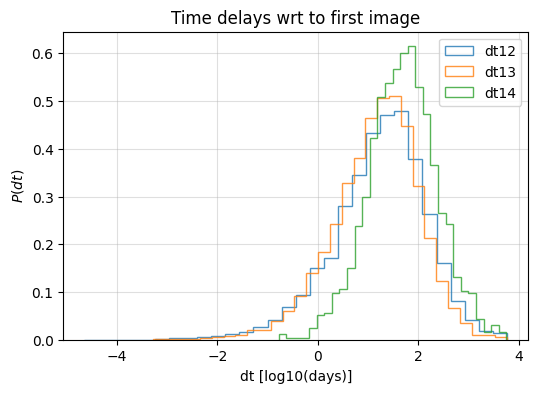

In [9]:
# plot time delays
plt.figure(figsize=(6, 4))
plt.hist(log_t12, bins=30, alpha=0.8, label='dt12', density=True, histtype='step')
plt.hist(log_t13, bins=30, alpha=0.8, label='dt13', density=True, histtype='step')
plt.hist(log_t14, bins=30, alpha=0.8, label='dt14', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt to first image')
plt.show()

## KDE

In [10]:
from sklearn.neighbors import KernelDensity

kde_log_t12 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t12).reshape(-1,1))
kde_log_t13 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t13).reshape(-1,1))
kde_log_t14 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t14).reshape(-1,1))

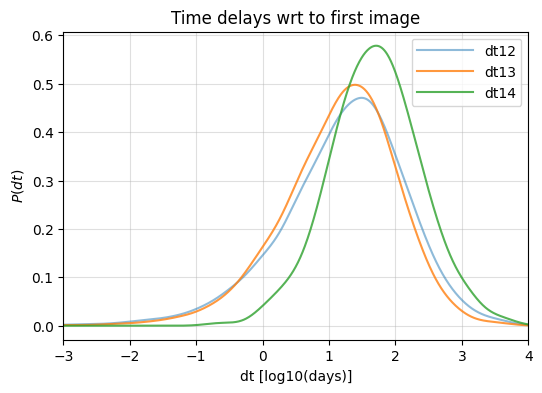

In [11]:
# plot
plt.figure(figsize=(6,4))
dt_log = np.linspace(-3, 4, 1000)
plt.plot(dt_log, np.exp(kde_log_t12.score_samples(dt_log.reshape(-1,1))), label='dt12', color='C0', linestyle='-', alpha=0.5)
plt.plot(dt_log, np.exp(kde_log_t13.score_samples(dt_log.reshape(-1,1))), label='dt13', color='C1', linestyle='-', alpha=0.8)
plt.plot(dt_log, np.exp(kde_log_t14.score_samples(dt_log.reshape(-1,1))), label='dt14', color='C2', linestyle='-', alpha=0.8)

plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt to first image')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-3, 4)
#plt.savefig("redshift_distribution_bns.png")
plt.show()

## corner plots

In [12]:
# time delays according to image type difference
# dn0 for [typeI,typeI] or [typeII,typeII]
# dn90 for [typeI,typeII] or [typeI,typeII]
img_type = lensed_params_detectable['image_type']
dt_eff = lensed_params_detectable['effective_geocent_time']
snr_l = lensed_params_detectable['optimal_snr_net']
mu = lensed_params_detectable['magnifications']

In [13]:
dt0 = []
dt90 = []
dmu0 = []
dmu90 = []

list_idx = np.array([[0,1],
                  [0,2],
                  [0,3],
                  [1,2],
                  [1,3],
                  [2,3],])

for j in range(len(img_type)):
    for idx in list_idx:
        dn = abs(img_type[j][idx[0]]-img_type[j][idx[1]])
        snr1 = snr_l[j][idx[0]]
        snr2 = snr_l[j][idx[1]]

        if dn==0 and snr1>8 and snr2>8:
            # tye I-I, II-II
            dt0.append(abs(dt_eff[j][idx[0]]-dt_eff[j][idx[1]])/ (24*3600))
            dmu0.append(abs(mu[j][idx[0]]/mu[j][idx[1]]))
        if dn==1 and snr1>8 and snr2>8:
            # tye I-I, II-II
            dt90.append(abs(dt_eff[j][idx[0]]-dt_eff[j][idx[1]])/ (24*3600))
            dmu90.append(abs(mu[j][idx[0]]/mu[j][idx[1]]))

dt0 = np.array(dt0)
dt90 = np.array(dt90)
dmu0 = np.array(dmu0)
dmu90 = np.array(dmu90)
            

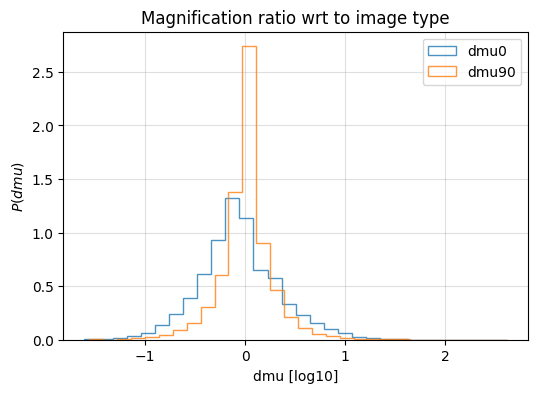

In [14]:
# plot magnification ratio
log_dmu0 = np.log10(dmu0)
log_dmu90 = np.log10(dmu90)
plt.figure(figsize=(6, 4))
plt.hist(log_dmu0, bins=30, alpha=0.8, label='dmu0', density=True, histtype='step')
plt.hist(log_dmu90, bins=30, alpha=0.8, label='dmu90', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'dmu [log10]')
plt.ylabel(r'$P(dmu)$') 
plt.title('Magnification ratio wrt to image type')
plt.show()


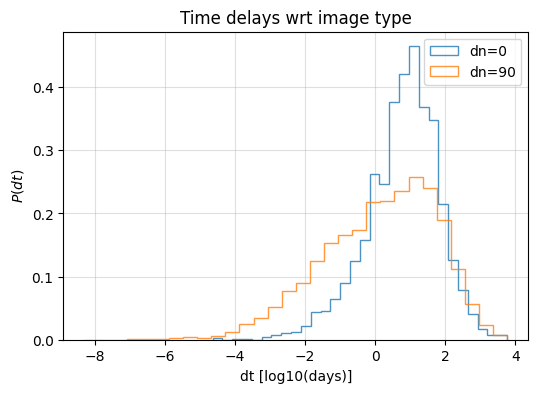

In [15]:
log_dt0 = np.log10(dt0)
log_dt90 = np.log10(dt90)

# plot time delays
plt.figure(figsize=(6, 4))
plt.hist(log_dt0, bins=30, alpha=0.8, label='dn=0', density=True, histtype='step')
plt.hist(log_dt90, bins=30, alpha=0.8, label='dn=90', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt image type')
plt.show()

In [16]:
# kde for time delays
from sklearn.neighbors import KernelDensity

kde_log_dt0 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(np.array(log_dt0).reshape(-1,1))
kde_log_dt90 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(np.array(log_dt90).reshape(-1,1))

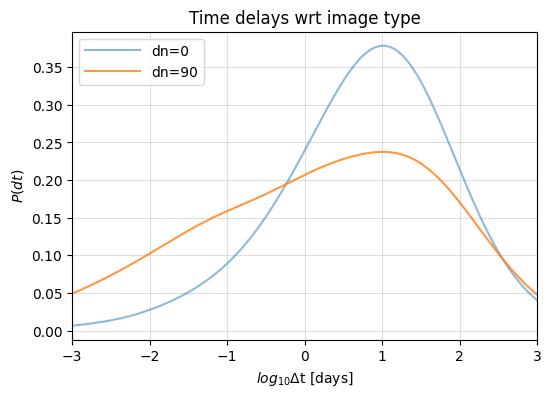

In [17]:
# plot
plt.figure(figsize=(6,4))
dt_log = np.linspace(-3, 3, 1000)
plt.plot(dt_log, np.exp(kde_log_dt0.score_samples(dt_log.reshape(-1,1))), label='dn=0', color='C0', linestyle='-', alpha=0.5)
plt.plot(dt_log, np.exp(kde_log_dt90.score_samples(dt_log.reshape(-1,1))), label='dn=90', color='C1', linestyle='-', alpha=0.8)

plt.xlabel(r'$log_{10}\Delta$t [days]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt image type')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-3, 3)
#plt.savefig("redshift_distribution_bns.png")
plt.show()

In [18]:
# unlensed population, detectable 
unlensed_params = ler.selecting_n_unlensed_detectable_events(
    size=10000,
    batch_size=50000,
    snr_threshold=8,
    resume=False,
    output_jsonfile="n_unlensed_params_bbh.json",
    meta_data_file="meta_data_unlensed_bbh.json",
)

collected number of events =  0
collected number of events =  230
total number of events =  50000
total unlensed rate (yr^-1): 476.2053242312996
collected number of events =  458
total number of events =  100000
total unlensed rate (yr^-1): 474.13486629985914
collected number of events =  652
total number of events =  150000
total unlensed rate (yr^-1): 449.9795237663874
collected number of events =  853
total number of events =  200000
total unlensed rate (yr^-1): 441.52515387967236
collected number of events =  1057
total number of events =  250000
total unlensed rate (yr^-1): 437.69480670650756
collected number of events =  1249
total number of events =  300000
total unlensed rate (yr^-1): 431.0003260615168
collected number of events =  1454
total number of events =  350000
total unlensed rate (yr^-1): 430.063690330627
collected number of events =  1641
total number of events =  400000
total unlensed rate (yr^-1): 424.70268318671884
collected number of events =  1835
total number of

In [19]:
unlensed_params_detectable = get_param_from_json("ler_data/n_unlensed_params_bbh.json")

In [20]:
# simulating time delay difference and magnification ratio, for unlensed population
size = 10000

t = unlensed_params_detectable["geocent_time"]
mu = unlensed_params_detectable["luminosity_distance"]

len_ = len(t)
t_ = []
mu_ = []
idx1 = np.random.choice(np.arange(0,len_), size, replace=False)
idx2 = np.random.choice(np.arange(0,len_), size, replace=False)
t_.append(t[idx2] - t[idx1])
mu_.append(mu[idx2] / mu[idx1])

dt_ul = np.abs(np.array(t_).flatten()) / (60 * 60 * 24)  # in days
dmu_ul = np.abs(np.array(mu_).flatten())**2

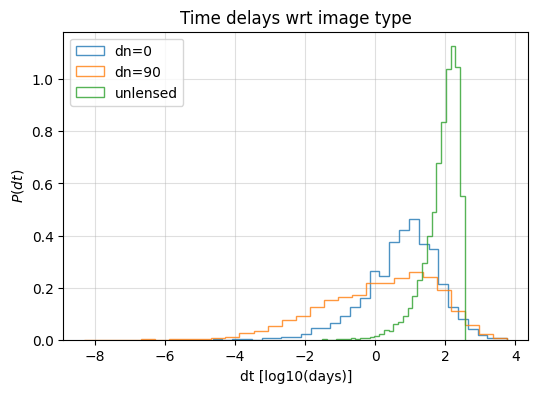

In [21]:
log_dt0 = np.log10(dt0)
log_dt90 = np.log10(dt90)
# unlensed
log_dt_ul = np.log10(dt_ul)
log_dmu_ul = np.log10(dmu_ul)
# avoid inf
idx_nan = np.isinf(log_dt_ul)
log_dt_ul = log_dt_ul[~idx_nan]
log_dmu_ul = log_dmu_ul[~idx_nan]

# plot time delays
plt.figure(figsize=(6, 4))
plt.hist(log_dt0, bins=30, alpha=0.8, label='dn=0', density=True, histtype='step')
plt.hist(log_dt90, bins=30, alpha=0.8, label='dn=90', density=True, histtype='step')
plt.hist(log_dt_ul, bins=30, alpha=0.8, label='unlensed', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt image type')
plt.show()

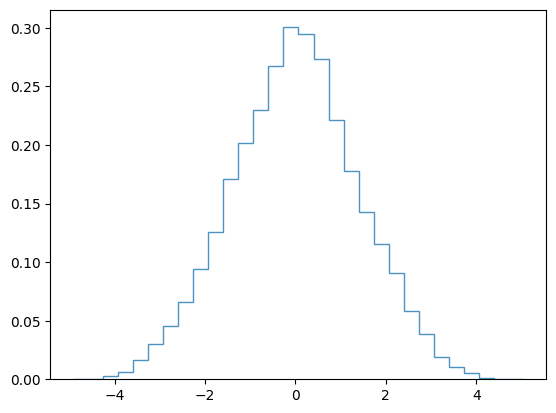

In [22]:
plt.hist(log_dmu_ul, bins=30, alpha=0.8, label='unlensed', density=True, histtype='step')
plt.show()

In [23]:
# kde for time delays
from sklearn.neighbors import KernelDensity

kde_log_dt0 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(np.array(log_dt0).reshape(-1,1))
kde_log_dt90 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(np.array(log_dt90).reshape(-1,1))
kde_log_dt_ul = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(np.array(log_dt_ul).reshape(-1,1))

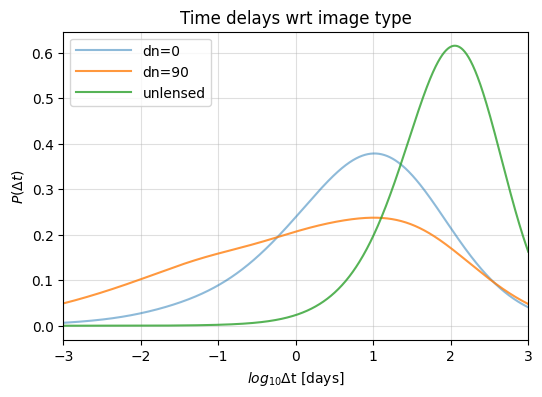

In [51]:
# plot
plt.figure(figsize=(6,4))
dt_log = np.linspace(-3, 3, 1000)
plt.plot(dt_log, np.exp(kde_log_dt0.score_samples(dt_log.reshape(-1,1))), label='dn=0', color='C0', linestyle='-', alpha=0.5)
plt.plot(dt_log, np.exp(kde_log_dt90.score_samples(dt_log.reshape(-1,1))), label='dn=90', color='C1', linestyle='-', alpha=0.8)
plt.plot(dt_log, np.exp(kde_log_dt_ul.score_samples(dt_log.reshape(-1,1))), label='unlensed', color='C2', linestyle='-', alpha=0.8)

plt.xlabel(r'$log_{10}\Delta$t [days]')
plt.ylabel(r'$P(\Delta t)$')
plt.title('Time delays wrt image type')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-3, 3)
#plt.savefig("redshift_distribution_bns.png")
plt.show()

## magnification plot

In [16]:
# magnification
# select only detectable
mu = lensed_params_detectable['magnifications']
mu = abs(np.array(mu).flatten())
idx_nan = np.isnan(mu)
# non nan values
mu = mu[~idx_nan]

# snr 
snr = lensed_params_detectable['optimal_snr_net']
snr = np.array(snr).flatten()
snr = snr[~idx_nan]
idx_detectable = snr>8
mu = mu[idx_detectable]

In [18]:
mu_ = np.sort(mu)
mu_

array([7.18355283e-01, 7.87036153e-01, 9.49931412e-01, ...,
       9.38818818e+02, 9.67967062e+02, 1.52804512e+03])

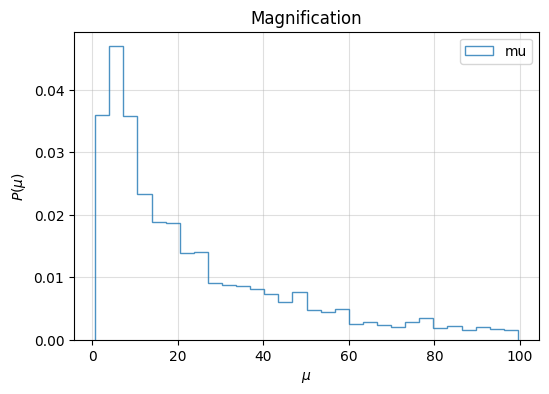

In [19]:
# plot magnification
mu_ = mu[mu<100]
plt.figure(figsize=(6, 4))
plt.hist(mu_, bins=30, alpha=0.8, label='mu', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$P(\mu)$')
plt.title('Magnification')
plt.show()

## Contour plot

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [ ]:
# unlened
log_dmu = log_dmu_ul 
log_dt = log_dt_ul

# Perform a kernel density estimation (KDE)
xy = np.vstack([log_dt, log_dmu])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels1 = np.percentile(kde, [10, 40, 68, 95])

# Create a grid for contour plot
xgrid = np.linspace(min(log_dt), max(log_dt), 1000)
ygrid = np.linspace(min(log_dmu), max(log_dmu), 1000)
X1, Y1 = np.meshgrid(xgrid, ygrid)
Z1 = gaussian_kde(xy)(np.vstack([X1.ravel(), Y1.ravel()])).reshape(X1.shape)

In [58]:
# dn=0
#lensed
log_dmu = log_dmu0
log_dt = log_dt0

# Perform a kernel density estimation (KDE)
xy = np.vstack([log_dt, log_dmu])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels2 = np.percentile(kde, [10, 40, 68, 95])

# Create a grid for contour plot
xgrid = np.linspace(min(log_dt), max(log_dt), 1000)
ygrid = np.linspace(min(log_dmu), max(log_dmu), 1000)
X2, Y2 = np.meshgrid(xgrid, ygrid)
Z2 = gaussian_kde(xy)(np.vstack([X2.ravel(), Y2.ravel()])).reshape(X2.shape)

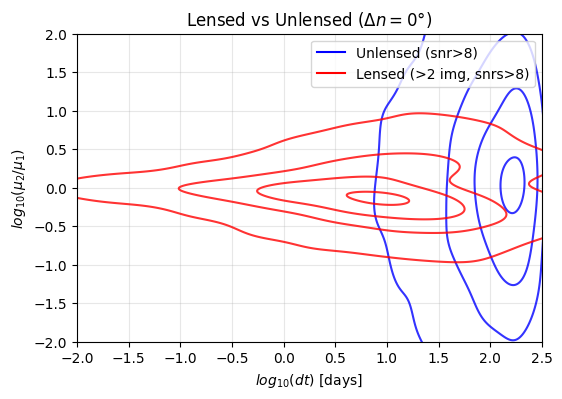

In [68]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels1, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.contour(X2, Y2, Z2, levels=levels2, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.xlabel("$log_{10}(dt)$ [days]")
plt.ylabel(r"$log_{10}(\mu_2/\mu_1)$")
plt.title(r"Lensed vs Unlensed ($\Delta n=0\degree$)")
# plt.colorbar(contour1, label='Density')
plt.xlim(-2, 2.5)
plt.ylim(-2, 2)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='blue', label='Unlensed (snr>8)')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='red', label='Lensed (>2 img, snrs>8)')
plt.legend(handles=[proxy1, proxy2])
plt.show()

In [73]:
#lensed
log_dmu = log_dmu90
log_dt = log_dt90

# Perform a kernel density estimation (KDE)
xy = np.vstack([log_dt, log_dmu])
kde = gaussian_kde(xy)(xy)

# Define the levels for contour as percentiles of the density
levels3 = np.percentile(kde, [10, 40, 68, 95])

# Create a grid for contour plot
xgrid = np.linspace(min(log_dt), max(log_dt), 1000)
ygrid = np.linspace(min(log_dmu), max(log_dmu), 1000)
X3, Y3 = np.meshgrid(xgrid, ygrid)
Z3 = gaussian_kde(xy)(np.vstack([X3.ravel(), Y3.ravel()])).reshape(X3.shape)

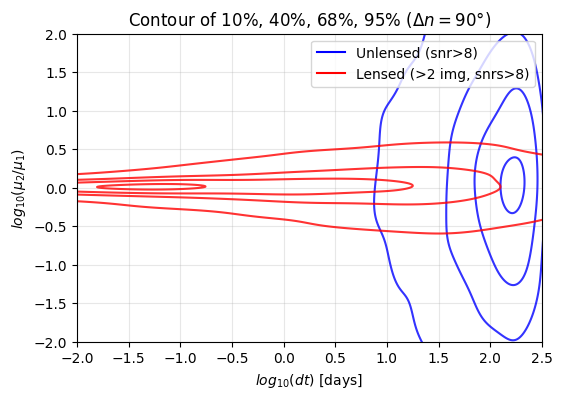

In [74]:
# Plotting
plt.figure(figsize=(6, 4))
plt.contour(X1, Y1, Z1, levels=levels1, colors=['blue', 'blue', 'blue', 'blue', 'blue'], alpha=0.8)
plt.contour(X3, Y3, Z3, levels=levels3, colors=['red', 'red', 'red', 'red', 'red'], alpha=0.8)
plt.xlabel("$log_{10}(dt)$ [days]")
plt.ylabel(r"$log_{10}(\mu_2/\mu_1)$")
plt.title(r"Contour of 10%, 40%, 68%, 95% ($\Delta n=90\degree$)")
# plt.colorbar(contour1, label='Density')
plt.xlim(-2, 2.5)
plt.ylim(-2, 2)
plt.grid(alpha=0.3)
# Add legend
# Create proxy artists for legend
proxy1 = plt.Line2D([0], [0], linestyle='-', color='blue', label='Unlensed (snr>8)')
proxy2 = plt.Line2D([0], [0], linestyle='-', color='red', label='Lensed (>2 img, snrs>8)')
plt.legend(handles=[proxy1, proxy2])
plt.show()

## 4-image case

In [ ]:
# data generation
ler = LeR(
    npool=4,
    event_type="BBH",
    verbose=False, 
    # geocent_time_min=1126259462.4,
    # geocent_time_max=1126259462.4+365*24*3600*10,
    )

In [ ]:
# data generation
lensed_params = ler.selecting_n_lensed_detectable_events(
    size=10000,
    batch_size=50000,
    snr_threshold=8,
    num_img=4,
    resume=True,
    output_jsonfile="n_lensed_params_bbh_4img.json",
    meta_data_file="meta_data_lensed_bbh_4img.json",
)

In [26]:
# getting data from json
lensed_params_detectable = get_param_from_json("ler_data/n_lensed_params_bbh_4img.json")

In [27]:
# select according to arrival time
dt_eff = lensed_params_detectable['effective_geocent_time']

dt12 = abs(dt_eff[:,1]-dt_eff[:,0])/ (24*3600)
dt13 = abs(dt_eff[:,2]-dt_eff[:,0])/ (24*3600)
dt14 = abs(dt_eff[:,3]-dt_eff[:,0])/ (24*3600)

# select only detectable
snr_l = lensed_params_detectable['optimal_snr_net']
dt12 = dt12[snr_l[:,1]>8]
dt13 = dt13[snr_l[:,2]>8]
dt14 = dt14[snr_l[:,3]>8]

# select only non-nan values
dt12 = dt12[~np.isnan(dt12)]
dt12 = dt12[~np.isnan(dt12)]
dt12 = dt12[~np.isnan(dt12)]

log_t12 = np.log10(dt12)
log_t13 = np.log10(dt13)
log_t14 = np.log10(dt14)

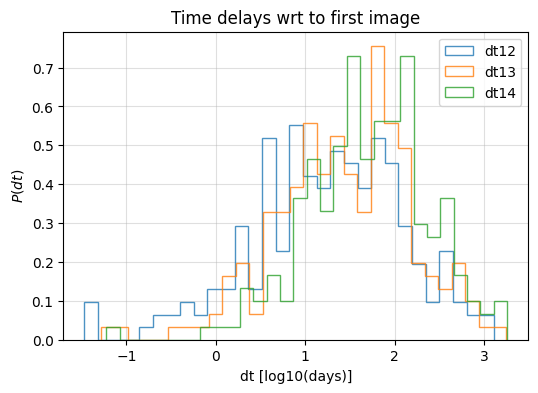

In [28]:
# plot time delays
plt.figure(figsize=(6, 4))
plt.hist(log_t12, bins=30, alpha=0.8, label='dt12', density=True, histtype='step')
plt.hist(log_t13, bins=30, alpha=0.8, label='dt13', density=True, histtype='step')
plt.hist(log_t14, bins=30, alpha=0.8, label='dt14', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt to first image')
plt.show()

In [29]:
# time delays according to image type difference
# dn0 for [typeI,typeI] or [typeII,typeII]
# dn90 for [typeI,typeII] or [typeI,typeII]
img_type = lensed_params_detectable['image_type']
dt_eff = lensed_params_detectable['effective_geocent_time']
snr_l = lensed_params_detectable['optimal_snr_net']

In [30]:
dt0 = []
dt90 = []
list_idx = np.array([[0,1],
                  [0,2],
                  [0,3],
                  [1,2],
                  [1,3],
                  [2,3],])

for j in range(len(img_type)):
    for idx in list_idx:
        dn = abs(img_type[j][idx[0]]-img_type[j][idx[1]])
        snr1 = snr_l[j][idx[0]]
        snr2 = snr_l[j][idx[1]]

        if dn==0 and snr1>8 and snr2>8:
            # tye I-I, II-II
            dt0.append(abs(dt_eff[j][idx[0]]-dt_eff[j][idx[1]])/ (24*3600))
        if dn==1 and snr1>8 and snr2>8:
            # tye I-I, II-II
            dt90.append(abs(dt_eff[j][idx[0]]-dt_eff[j][idx[1]])/ (24*3600))

dt0 = np.array(dt0)
dt90 = np.array(dt90)
            

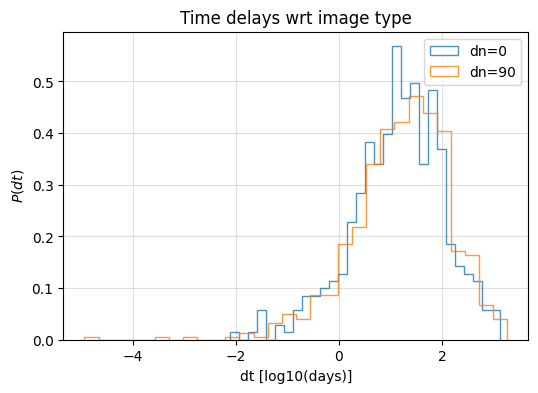

In [31]:
log_dt0 = np.log10(dt0)
log_dt90 = np.log10(dt90)

# plot time delays
plt.figure(figsize=(6, 4))
plt.hist(log_dt0, bins=30, alpha=0.8, label='dn=0', density=True, histtype='step')
plt.hist(log_dt90, bins=30, alpha=0.8, label='dn=90', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays wrt image type')
plt.show()